In [2]:
from qutip import *
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

class sideband:
    def __init__(self,**params) -> None:
        '''
        level,Tstep,t_edge,|||
        w,yita,g,|||
        L,wd,phid,amp,sp,|||
        rho0,rho_tar|||

        (w+k)n-k/12(x**4)=wn-k/2*ad*ad*a*a
        '''

        self.params={
        # qcircuit
        'level':3,          'hascoupler':False,
        # qubtrit params,   GHz/2pi
        'w':[7,5,0],        'yita':[100,300,0],         'g':[100,0,0],
        # drive params,      GHz/2pi,rad,1
        'wd':[5.15,6],      'phid':[0,0],               'sp':[1,0],
        # envelope,         ns,ns,GHz/2pi
        'L':100,            't_edge':10,               'amp':0.1,
        # simulate
        'Tstep':1000,       'rho0':0,                   'rho_tar':None,
        }
        self.params.update(params)
        self.__setparams(self.params)
   
    def __setparams(self,dic):
        for p in dic:
            setattr(self,p,dic[p])
        
        # qcircuit
        global n
        n=self.level

        # qubtrit params,   GHz,MHz,MHz
        self.H0=self.__H0
        self.ee,self.es,self.proj=self.__eigen
        self.e1,self.e2=self.ee[2],self.ee[1]
        self.e11,self.e22=self.ee[self.to(1)],self.ee[self.to(2)]
        
        # params pre_guess
        self.ws_g=self.e11/2
        self.wp_g=(self.e22-self.e11)/2
        self.ks_g=1/(self.e1-self.ws_g)+1/(self.e1+self.ws_g)
        self.kp_g=1/(self.e1-self.wp_g)+1/(self.e1+self.wp_g)

        # self.ws_g=self.ws_g-self.yita[0]*\
        #     self.amp**2*(self.sp[0]*self.ks_g**2+self.sp[1]*self.kp_g**2)
        # self.wp_g=self.wp_g-self.yita[0]*\
        #     self.amp**2*(self.sp[0]*self.ks_g**2+self.sp[1]*self.kp_g**2)

        self.ds_g=2*((self.amp*self.ks_g)**2)*\
            self.yita[0]*self.g[0]/(self.e1-self.e2)
        self.dp_g=4*((self.amp*self.kp_g)**2)*\
            self.yita[0]*self.g[0]/(self.e1-self.e2)
        self.T_g=2/self.ds_g

        # drive
        self.ws,self.wp=self.wd[0],self.wd[1]
        self.envelope=self.__envelope
        self.ks,self.kp,self.sp=self.__sp
        self.DS,self.HD=self.__DS,self.__HD

 
        # simulate
        self.H=[2*np.pi*self.H0,[2*np.pi*self.HD,self.DS]]
        self.tlist=np.linspace(0,self.L,self.Tstep)
        if self.rho_tar==None:
            self.rho_tar=self.rho0+1
    
    def update(self,**params):
        self.params.update(params)
        self.__setparams(self.params)


    @property
    def __envelope(self):
        return lambda t,args:\
            self.amp*(0.5*np.cos(np.pi*t/self.t_edge-np.pi)+0.5)\
        if 0<=t<=self.t_edge else\
            self.amp*(0.5*np.cos(np.pi*(t-self.L)/self.t_edge-np.pi)+0.5)\
        if (self.L-self.t_edge)<=t<=self.L else\
            self.amp\
        if self.t_edge<t<(self.L-self.t_edge) else 0
    @property 
    def __sp(self):
        sp=self.sp
        ks,kp,spp=0,0,0
        if len(self.wd)>=2:
            # print(self.wd)
            ks=1/(self.e1-self.ws)+1/(self.e1+self.ws)
            kp=1/(self.e1-self.wp)+1/(self.e1+self.wp)
            spp=[sp[0],np.sqrt(0.5*sp[1])*np.abs(ks/kp)]
        return ks,kp,spp
    @property
    def __DS(self):
        DS=lambda t,args:0
        def cos(sp,a,w,phi): 
            return lambda t,args:sp*a(t,args)*np.cos(2*np.pi*w*t+phi)
        def add(f1,f2):
            return lambda t,args:f1(t,args)+f2(t,args)

        for i in range(len(self.wd)):
            DS=add(cos(self.sp[i],self.envelope,self.wd[i],self.phid[i]),DS)
        return DS
    
    
    @property
    def __HD(self):
        a=destroy(n)
        ad=create(n)
        I=qeye(n)
        D=tensor(a+ad,I)
        return D       
    
    
    def plot(self,target='DS'):
        if target=='DS':
            func=self.DS
        elif target=='envelope':
            func=self.envelope
        fix,ax=plt.subplots()
        ax.plot(self.tlist,list(map(func,self.tlist,self.tlist)))
    
    @property
    def __H0(self):
        w,g,yita=self.w,self.g,self.yita
        a,ad,I=destroy(15),create(15),qeye(n)
        x=a+ad
        def trunc(x):
            return Qobj(x[:n,:n])

        h0=(w[0]+yita[0])*ad*a-yita[0]/12*(x**4)
        h1=(w[1]+yita[1])*ad*a-yita[1]/12*(x**4)

        h0,h1=trunc(h0),trunc(h1)
        G01=g[0]*tensor(trunc(x),trunc(x))

        H0=tensor(h0,I)+tensor(I,h1)+G01
        return H0 
            # return trunc(h0)
    @property
    def __eigen(self):
        eigen=self.H0.eigenstates()
        ee=[e-eigen[0][0] for e in eigen[0]]
        es=eigen[1]
        proj=[s*s.dag() for s in es]
        return ee,es,proj
    
    def to(self,x):
        #n=3,4,5 p22=p[8,11,12] ,assume 11,22 setten at middle of exciting number subspace
        #without consider 30 exceed 04
        #assume w2=2w-yita,w3=3w-2yita
        if x==0:
            return 0
        elif x==1:
            return 4
        elif x==2:
            if n==3:
                return 8
            elif n==4:
                return 11
            elif n==5:
                return 12
            elif n>=6:
                return 13



    def g_Level(self,target=None,g=None):
        if g==None:
            g=self.g[0]*1000
        z=[]
        glist=np.linspace(0,g,100)
        for p in glist:
            self.update(g=[p,0,0])
            ee=self.ee
            ee=[e-ee[0] for e in ee]
            # z.append(ee[2]-ee[1]-2)
            z.append(ee)
        z=np.transpose(z)
        fix,ax=plt.subplots()
        if target==None:
            target=4
            ax.plot(glist,np.transpose(z))
        else:
            # ax.plot(glist,np.transpose(z)[target])
            ax.plot(glist,[i-0*z[target][0] for i in z[target]])
        return z[target][-1]-z[0][-1]
        # return z[target][0]-z[0][0]        

    def run(self,plot=False,population=True,bloch=True):
        proj,to,tlist,H=self.proj,self.to,self.tlist,self.H
        rho0,rho_tar=self.rho0,self.rho_tar

        rho0=proj[to(rho0)]

        e_ops=[proj[to(0)],proj[to(1)],proj[to(2)]]

        result=mesolve(H,rho0,tlist,e_ops=e_ops)
        tot,error=[],[]
        for i in range(len(result.expect[0])):
            tot.append(
            result.expect[0][i]+result.expect[1][i]+result.expect[2][i]
            )
            error.append(
            result.expect[0][i]+result.expect[1][i]+result.expect[2][i]\
                -result.expect[rho_tar][i]
            )
        result.expect.append(tot)
        result.expect.append(error)
        result.min=min(error)
        
        if plot:
            self.GateProcess(result=result,population=population,bloch=bloch)
        return result

    def GateProcess(self,result,population=True,bloch=True):
        if population:
            fig, ax = plt.subplots()
            ax.plot(result.times ,
            # np.transpose([result.expect[p]]))
            np.transpose([result.expect[0],result.expect[1],result.expect[2],\
                          result.expect[3],result.expect[4]]))
            ax.set_xlabel('t/ns')
            ax.set_ylabel('Population')
            ax.legend(['P00','P11','P22','tot','tot-target'])
            plt.show()
        if bloch:
            b=Bloch()
            b.add_points([result.expect[0],result.expect[1],result.expect[2]],'l')
            b.show()

    def scan_wd(self,wstart,wstop,wstep,sp=0,runplot=False,plot=True):
        '''
        sp=0,wd=[w_scan,wp]
        sp=1,wd=[ws,w_scan]
        '''
        rho0,rho_tar=self.rho0,self.rho_tar
        wdlist=np.linspace(wstart,wstop,wstep)
        wd=self.wd
        z=[]
        for w in wdlist:
            wd[sp]=w
            # wdt=[lambda t,args:wd]
            self.update(wd=wd)
            result=self.run(plot=runplot)
            z.append(np.transpose(result.expect))
        z=np.transpose(z)
        print(shape(z))

        if plot:
            self.imshow([z,wstart,wstop,wstep],rho_tar)

        return [z,wstart,wstop,wstep,wdlist]
  
    def find_w_mat(self,input,target=None,plot=False):
        z,wstart,wstop,wstep,wdlist=input[0],input[1],input[2],input[3],input[4]
        dom=wstop-wstart
        dpi=(wstop-wstart)/wstep
        error=list(np.min(z[-1],axis=0))
        w_arg=np.argmin(error,axis=0)
        wm_guess=wdlist[w_arg]
        isside= w_arg==0 or w_arg==wstep-1
        return [wm_guess,dom,dpi,isside]


    ###############################################

    ###############################################

    def auto_scan_scope(self,sp=0,dpim=1/1000000,plot=False):
        ws,wp,wd=self.ws_g,self.wp_g,self.wd
        wsp=[ws,wp]
        dw=self.e1-self.e2
        dpi0=0.03*dw
        dpi=dpi0
        w=[wsp[sp]-dpi,wsp[sp],wsp[sp]+dpi]
        error=[0,0,0]

        z=[]
        wdlist=[]

        def iter(i):
            wd[sp]=w[i]
            self.update(wd=wd)
            result=self.run()
            error[i]=np.min(result.expect[-1])
            wdlist.append(w[i])
            z.append(np.transpose(result.expect))

        T=2*self.t_edge+0.3*1/(self.ds_g*(1-sp)+self.dp_g*sp)
        self.update(L=T)
        print(f'T for scan:{T}')

        for i in [0,2]:
            iter(i)
    
        while dpi>dpim:
            print(w)
            if error[0]>error[2]:
                    w[0]=w[1]
                    iter(0)
                    w[1]=(w[0]+w[2])/2
            elif error[0]<=error[2]:
                    w[2]=w[1]
                    iter(2)
                    w[1]=(w[2]+w[0])/2
            dpi=dpi/2

        print([w[0],error[0]])
        z=np.transpose(z)
        input=[z,wsp[sp]-dpi0,wsp[sp]+dpi0,100]
        self.imshow(input=input,target=self.rho_tar)
        return [[w[0],error[0]],input]

    def imshow(self,input,target=-1):
        z,wstart,wstop,wstep=input[0],input[1],input[2],input[3]
        # print(shape(z))
        # plt.imshow(z[target],extent=[wstart,wstop,self.tlist[-1],self.tlist[0]],\
        # aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),interpolation='none')
        plt.imshow(z[target],extent=[0,wstop-wstart,self.tlist[-1],self.tlist[0]],\
        aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),interpolation='none')
        plt.colorbar()
        plt.show()


c:\Users\1163080609\anaconda3\Lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


T_g=273.9355424450384,ws_g=4.444324760355917,wp_g=4.2275215821301


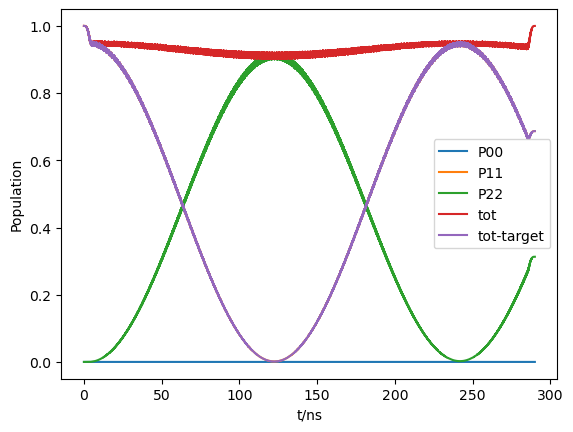

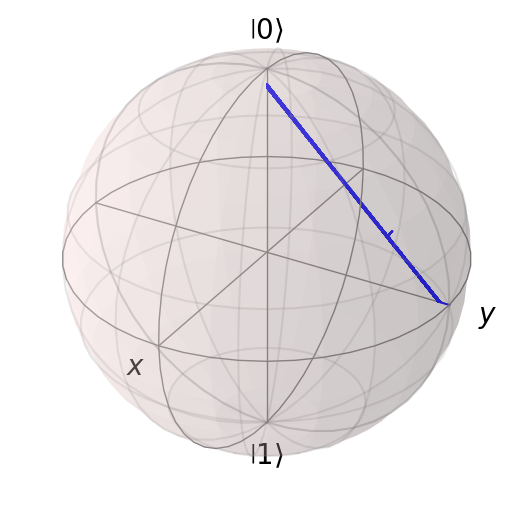

Result object with mesolve data.
--------------------------------
expect = True
num_expect = 3, num_collapse = 0

In [130]:
4.2334056587568565
wd=[4.437026771111823,4.2334056587568565]
# wd=[5.425560761023559,5.3109182561829]
a=sideband(level=4,Tstep=10000,t_edge=5,
w=[5,4],yita=[0.3,0.3],g=[0.15],
L=290,wd=wd,sp=[0,1],amp=0.15,
rho0=1,rho_tar=2)

print(f'T_g={a.T_g},ws_g={a.ws_g},wp_g={a.wp_g}')
a.run(plot=True)
# a.plot('envelope')
# a.ws_g
# b=a.scan_wd(4.4365,4.438,10,0,runplot=False)
# auto=a.auto_scan_scope(sp=1,plot=True)

T_g=273.9355424450384,ws_g=4.444324760355917,wp_g=4.2275215821301
T for scan:48.4866816150959
[4.195715342785737, 4.2275215821301, 4.2593278214744625]
[4.2275215821301, 4.243424701802281, 4.2593278214744625]
[4.2275215821301, 4.235473141966191, 4.243424701802281]
[4.2275215821301, 4.231497362048145, 4.235473141966191]
[4.231497362048145, 4.233485252007168, 4.235473141966191]
[4.231497362048145, 4.232491307027656, 4.233485252007168]
[4.232491307027656, 4.2329882795174125, 4.233485252007168]
[4.2329882795174125, 4.233236765762291, 4.233485252007168]
[4.233236765762291, 4.23336100888473, 4.233485252007168]
[4.23336100888473, 4.233423130445949, 4.233485252007168]
[4.23336100888473, 4.2333920696653395, 4.233423130445949]
[4.2333920696653395, 4.233407600055644, 4.233423130445949]
[4.2333920696653395, 4.233399834860492, 4.233407600055644]
[4.233399834860492, 4.233403717458068, 4.233407600055644]
[4.233403717458068, 4.2334056587568565, 4.233407600055644]
[4.2334056587568565, 0.6942941792765916

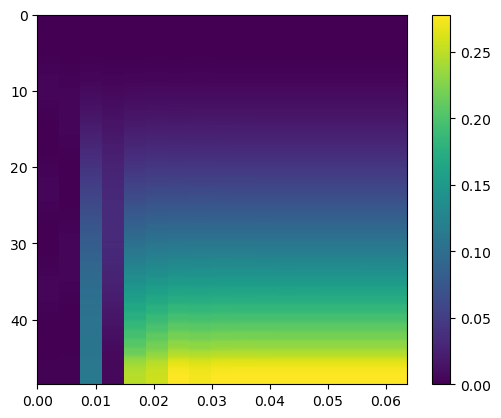

In [129]:
4.436575095593789
4.437026771111823
wd=[4.437026771111823,5.3109182561829]
# wd=[5.425560761023559,5.3109182561829]
a=sideband(level=4,Tstep=10000,t_edge=5,
w=[5,4],yita=[0.3,0.3],g=[0.15],
L=290,wd=wd,sp=[0,1],amp=0.15,
rho0=1,rho_tar=2)
print(f'T_g={a.T_g},ws_g={a.ws_g},wp_g={a.wp_g}')
# a.run(plot=True)
# a.plot('envelope')
# a.ws_g
# b=a.scan_wd(4.4365,4.438,10,0,runplot=False)
auto=a.auto_scan_scope(sp=1,plot=True)

T_g=273.9355424450384,ws_g=4.444324760355917,wp_g=4.2275215821301
T for scan:51.09033136675575
[4.412518521011554, 4.444324760355917, 4.476130999700279]
[4.444324760355917, 4.460227880028098, 4.476130999700279]
[4.444324760355917, 4.4522763201920075, 4.460227880028098]
[4.444324760355917, 4.448300540273962, 4.4522763201920075]
[4.444324760355917, 4.4463126503149395, 4.448300540273962]
[4.444324760355917, 4.445318705335428, 4.4463126503149395]
[4.444324760355917, 4.444821732845672, 4.445318705335428]
[4.444324760355917, 4.444573246600795, 4.444821732845672]
[4.444324760355917, 4.444449003478356, 4.444573246600795]
[4.444324760355917, 4.444386881917136, 4.444449003478356]
[4.444324760355917, 4.444355821136527, 4.444386881917136]
[4.444324760355917, 4.444340290746222, 4.444355821136527]
[4.444324760355917, 4.4443325255510695, 4.444340290746222]
[4.444324760355917, 4.444328642953494, 4.4443325255510695]
[4.444324760355917, 4.444326701654705, 4.444328642953494]
[4.444324760355917, 0.9633136

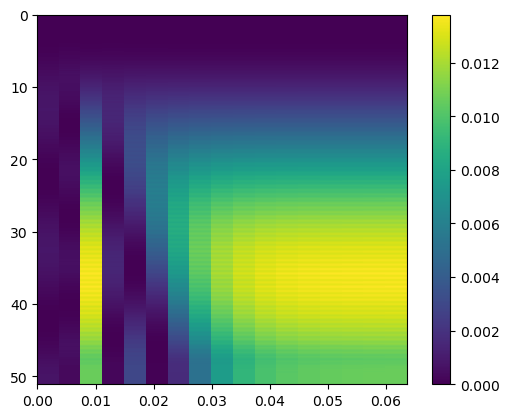

[[4.444324760355917, 0.9633136480081684],
 [array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          ...,
          [ 9.99238944e-01,  9.99661934e-01,  9.89319795e-01, ...,
            9.89371385e-01,  9.89345791e-01,  9.89332716e-01],
          [ 9.99238944e-01,  9.99661934e-01,  9.89319795e-01, ...,
            9.89371386e-01,  9.89345791e-01,  9.89332717e-01],
          [ 9.99238944e-01,  9.99661934e-01,  9.89319795e-01, ...,
            9.89371386e-01,  9.89345791e-01,  9.89332717e-01]],
  
         [[ 1.42711907e-19,  1.42711907e-19,  1.42711907e-19, ...,
            1.42711907e-19,  1.42711907e-19,  1.42711907e-19],
          [ 1.61280044e-19,  

In [3]:
wd=[4.437,5.3109182561829]
# wd=[5.425560761023559,5.3109182561829]
a=sideband(level=4,Tstep=10000,t_edge=5,
w=[5,4],yita=[0.3,0.3],g=[0.15],
L=100,wd=wd,sp=[1,0],amp=0.15,
rho0=0,rho_tar=1)
print(f'T_g={a.T_g},ws_g={a.ws_g},wp_g={a.wp_g}')
# a.run(plot=True)
# a.plot('envelope')
# a.ws_g
# b=a.scan_wd(4.4365,4.438,10,0,runplot=False)
a.auto_scan_scope(plot=True)

136.8048953443228


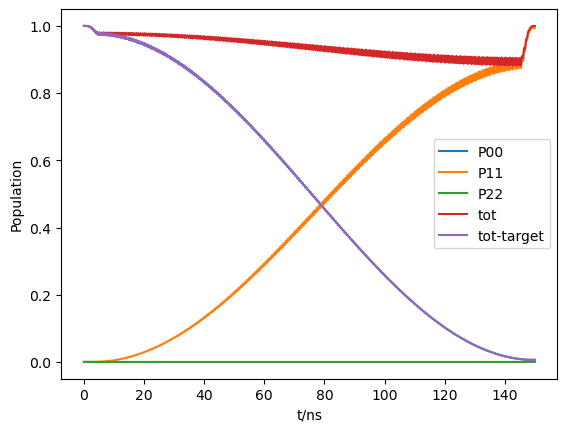

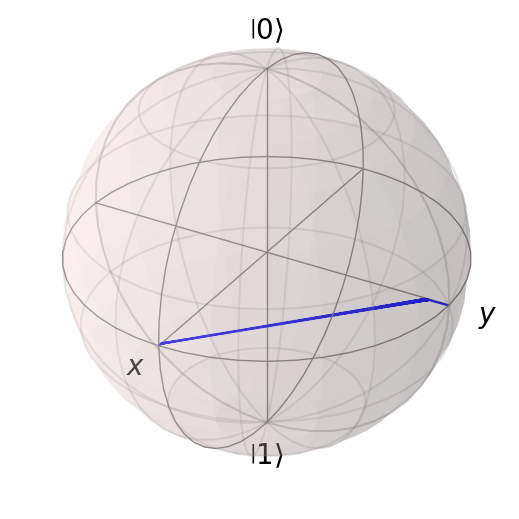

Result object with mesolve data.
--------------------------------
expect = True
num_expect = 3, num_collapse = 0

In [96]:
wd=[6-0.0726,5.3109182561829]
# wd=[5.425560761023559,5.3109182561829]
a=sideband(level=4,Tstpe=10000,t_edge=5,
w=[7,5],yita=[0.5,0.1],g=[0.3],
L=50,wd=wd,sp=[1,0],amp=0.3,
rho0=0,rho_tar=1)
print(a.T_g)
a.run(plot=True)
# a.ws_g
# b=a.scan_wd(6-0.074,6-0.071,10,0,runplot=False)

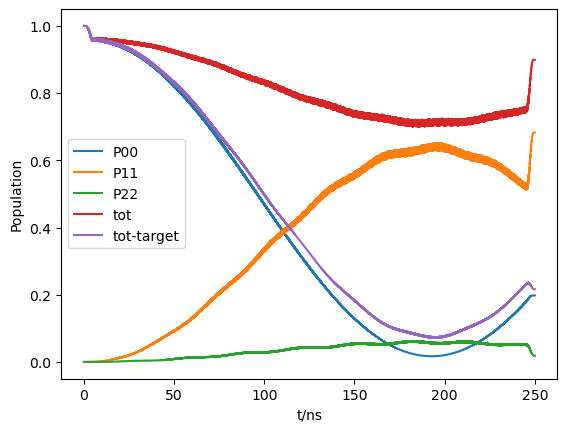

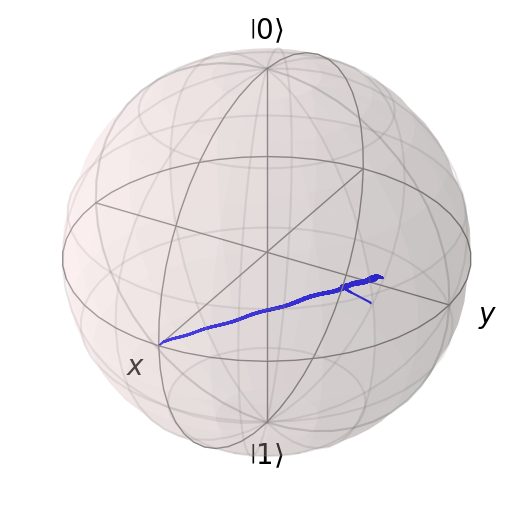

Result object with mesolve data.
--------------------------------
expect = True
num_expect = 3, num_collapse = 0

In [93]:
wd=[5.4628,5.3109182561829]
# wd=[5.425560761023559,5.3109182561829]
a=sideband(level=4,Tstep=10000,t_edge=5,
w=[6,5],yita=[0.3,0.1],g=[0.1],
L=250,wd=wd,sp=[1,0],amp=0.2,
rho0=0,rho_tar=1)
# print(a.T_g)
a.run(plot=True)
# a.plot('envelope')
# a.ws_g
# b=a.scan_wd(5.4625,5.463,10,0,runplot=False)

In [1]:
import numpy as np
# 1/np.sqrt(88/14)*np.sqrt(0.5*(1+np.sqrt(3)))
1/800

0.00125

192.3600429505337
(5, 1000, 10)


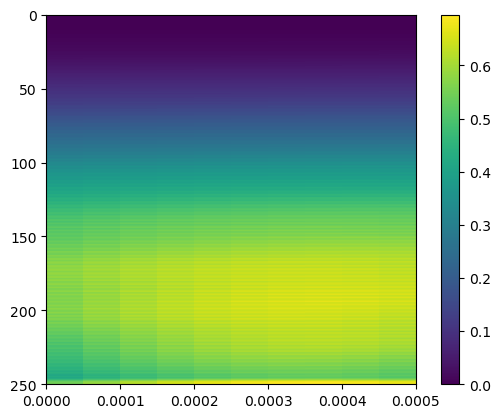

In [67]:
wd=[5.4628,5.3109182561829]
# wd=[5.425560761023559,5.3109182561829]
a=sideband(level=4,Tstpe=10000,t_edge=5,
w=[6,5],yita=[0.3,0.1],g=[0.1],
L=250,wd=wd,sp=[1,0],amp=0.2,
rho0=0,rho_tar=1)
print(a.T_g)
# a.run(plot=True)
# a.ws_g
b=a.scan_wd(5.4625,5.463,10,0,runplot=False)
# print(a.dp_g)
# print(a.ds_g)
# print(a.T_g)

# a.ws_g
# a.kp_g**2


In [ ]:
wd=[4.434592382431534,4.244749961774963]
4.244749961774963
a=sideband(level=4,Tstep=100000,t_edge=5,
w=[4.5,4],yita=[0.3,0.3],g=[0.1],

L=3000,wd=wd,sp_direct=[1,0],amp=0.15,
rho0=0)
# a.d_eff_g
# a.d_eff_g
# a.ksp_g
# a.wd
# b=a.auto_scan_scope(sp=0,)
amp_result=a.auto_scan_amp(0.02,0.2,19)
# res=a.run(plot=True)
# fit=a.wd_fit(res)
# res=a.run(plot=False)
# a.T_g/2
# c=a.wd_fit(res,sp=1)

auto_scan_amp start 
 astart,astop,astep=(0.02, 0.2, 19)
auto_scan_amp ,sp=0 ,amp=0.02
amp=0.02
auto_scan_scope start 
 sp=0
T for scan:746.5241746120429
iter_num=1
run start
run end
iter_num=2
run start


KeyboardInterrupt: 

In [4]:
>>> list1 = [3,2,4,1, 1]
>>> list2 = ['three', 'two', 'four', 'one', 'zero']
>>> list1, list2 = zip(*sorted(zip(list1, list2)))
>>> list1
(1, 1, 2, 3, 4)
>>> list2 
('one', 'zero', 'two', 'three', 'four')


TypeError: list indices must be integers or slices, not tuple

T_guess=125.53069116170171
[5.325994046079588, 5.425560761023559, 5.52512747596753]
[5.425560761023559, 5.475344118495544, 5.52512747596753]
[5.475344118495544, 5.500235797231537, 5.52512747596753]
[5.500235797231537, 5.512681636599533, 5.52512747596753]
[5.512681636599533, 5.518904556283531, 5.52512747596753]
[5.518904556283531, 5.52201601612553, 5.52512747596753]
[5.52201601612553, 5.52357174604653, 5.52512747596753]
[5.52357174604653, 5.52434961100703, 5.52512747596753]
[5.52434961100703, 5.524738543487279, 5.52512747596753]
[5.524738543487279, 5.5249330097274045, 5.52512747596753]
[5.5249330097274045, 5.525030242847468, 5.52512747596753]
[5.525030242847468, 5.525078859407499, 5.52512747596753]
[5.525078859407499, 5.525103167687514, 5.52512747596753]
[5.525103167687514, 5.525115321827522, 5.52512747596753]
[5.525115321827522, 0.9375162980542114]


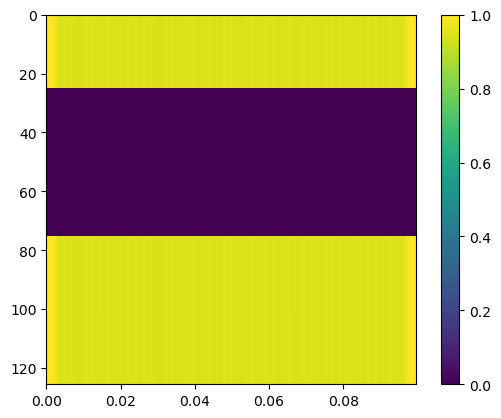

In [75]:
a=sideband(level=4,Tstpe=10000,t_edge=5,
w=[6,5],yita=[0.3,0.1],g=[0.1],
L=50,wd=[5.477318017009528,5.3+0*0.056],sp=[1,0],amp=0.2,
rho0=0,rho_tar=1)

# a.run(plot=True)
# a.to(2)
# a.e11/2-1*((a.dp_g*a.kp_g)**2+(a.ds_g*a.ks_g)**2)
# (a.dp_g*a.kp_g)**2
# (a.ds_g*a.ks_g)**2

# b=a.scan_wd(5.93-0.04,5.93+0.04,4,-1,rho0=0)
# a.imshow(b)
# a.rho0
#tcost=2,*wdstep for GateL=50,

# a.find_w_mat(b,plot=True)
ws=a.auto_scan_scope(0,plot=True)
# a.ks_g
# 1/a.ds

In [14]:
class aaa:
    def __init__(self) -> None:
        self.abc=1
    
    def f(self):
        self.abc+=1
b=aaa()
b.f()
b.f()
b.abc

3

In [ ]:
    ###############################################
    def fit_w_mat(self,input,target=None,plot=False):
        '''for rabi'''
        if target==None:
            target=self.rho0+1
        x,z=input[4],input[0]
        y=np.transpose(z[target][-1])
        if self.rho0==0:
            d_guess=2*(self.amp*self.ks)**2*self.yita[0]*self.g[0]/self.ee[1]
            guess=[5.927+0*self.ee[4]/2,d_guess,1,self.L-self.tupdown]
            print(guess)
        else :
            d_guess=8*(self.amp*self.kp)**2*self.yita[0]*self.g[0]/self.ee[1],
            guess=[(self.ee[self.s22]-self.ee[4])/2,d_guess,1,self.L]
            print(guess)
        def func(x,wm,d,F,t):
            # F=2
            # wm=5.928
            # return 0.5*(1/(1+((x-b)/d)**2))*(1-0*np.cos(t*(1+((x-b/d)**2))))
            # return np.abs(1/(1+(x-b)**2))
            # return F*1/(((x-wm)/d)**2+1)#*(0.5*(1-np.cos(t*np.sqrt(d**2+(x-wm)**2))))
            return F*1/(((x-5.927)/d)**2+1)#*(0.5*(1-np.cos(t*np.sqrt(d**2+(x-wm)**2))))
        
        # 拟合数据
        coeff, var_matrix = curve_fit(func,x,y,guess,\
            bounds=([self.ee[1],d_guess*0.5,0,0],[self.ee[2],d_guess*2,1,1000]))
 
        # 输出拟合参数
        
        if plot==True:
            print(f"wm,d,f,t: {coeff}")#, D/2pi: {coeff[1]}")
            plt.scatter(x, y)
            plt.plot(x, func(x,*coeff),color='red')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Linear Fit')
            plt.show()

        return 0


class optimize:
    '''optimize of gate parameters and visualize
    func_targ(result) --> value
    '''
    def __init__(self,name,start,step_start,step_m,dpi,gateclass,func_targ):
        self.name=name
        self.start,self.step,self.step_m,self.dpi=start,step_start,step_m,dpi
        self.gate,self.func=gateclass,func_targ
        self.dict_p={name:start}
    
    def opti_process(self,plot=True):
        name,gate,dic=self.name,self.gate,self.dict_p
        step,step_m,dpi=self.step,self.step_m,self.dpi
        para0=gate.params
        
        plist,expect_list=[],[]
        #确定范围
        while step>=dpi: 
            gate.params.update(dic)
            result=gate.run()
        result


    def imshow(self):

        plt.imshow(z[target],extent=[0,stop-start,self.tlist[-1],self.tlist[0]],\
        aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),interpolation='none')
        plt.colorbar()
        plt.show()

    def fit_w_mat(self,input,target=None,plot=False):
        '''for rabi'''
        if target==None:
            target=self.rho0+1
        x,z=input[4],input[0]
        y=np.transpose(z[target][-1])
        if self.rho0==0:
            d_guess=self.ds
            wm_guess=self.ee[4]/2
            guess=[wm_guess,d_guess,1,self.L-self.tupdown]
            print(guess)
        elif self.rho0==1:
            d_guess=self.dp
            wm_guess=(self.ee[self.s22]-self.ee[4])/2
            guess=[wm_guess,d_guess,1,self.L-self.tupdown]
            print(guess)

        def func(x,wm,d,F,t):
            # F=2
            # wm=5.928
            # d=0.004
            # t=150
            # wm=5.927
            # return F*1/(((x-wm)/d)**2+1)#*(0.5*(1-np.cos(t*np.sqrt(d**2+(x-wm)**2))))
            return F*1/(((x-wm)/d)**2+1)*(0.5*(1-np.cos(2*np.pi*t*np.sqrt(d**2+(x-wm)**2))))
        
        # 拟合数据
        print(type(wm_guess),type(d_guess))
        coeff, var_matrix = curve_fit(func,x,y,guess,\
            bounds=([wm_guess-0.1,d_guess*0.6,0,0*(self.L-5*self.tupdown)],\
                    [wm_guess+0.1,d_guess*1.5,1.0,1000+0*(self.L+5*self.tupdown)]))
 
        # 输出拟合参数
        
        if plot==True:
            print(f"wm,d,f,t: {coeff}")#, D/2pi: {coeff[1]}")
            plt.scatter(x, y)
            plt.plot(x, func(x,*coeff),color='red')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Linear Fit')
            plt.show()

        return coeff



In [ ]:
    def auto_scan_scope(self,sp=0):
        s22=self.s22
        ws=self.ee[4]/2
        wp=(self.ee[s22]-self.ee[4])/2
        dw=self.ee[2]-self.ee[1]

        if sp==0:
            T=2*self.tupdown+1/self.ds*0.2
            self.update(L=T)
            print(f'T_guess={T}')
            while dpi>0.0001:
                input1=self.scan_wd(ws-dw*0.05,ws+dw*0.05,7,sp=sp,plot=True)
                coeff1=self.find_w_mat(input=input1,plot=True)
                ws1=coeff1[0]
                print(f'({ws-dw/20},{ws+dw/20}),{ws1}')
                input2=self.scan_wd(ws1-dw/100,ws1+dw/100,10,sp=sp,rho0=self.rho0,plot=True)
                coeff2=self.find_w_mat(input=input2,plot=True)
                ws2=coeff2[0]
                print(f'({ws1-dw/100},{ws1+dw/100}),{ws2}')

                dpi=dpi/2
                dom=1
            # self.run(plot=True)
            return ws2
        if sp==1:
            T=2*self.tupdown+1/self.dp*0.1
            self.update(L=T)
            print(f'T={T}')
            input1=self.scan_wd(wp-dw/20,wp+dw/20,10,sp=sp,rho0=self.rho0,plot=True)
            coeff1=self.find_w_mat(input=input1,plot=True)
            wp1=coeff1[0]
            print(f'({wp-dw/20},{wp+dw/20}),{wp1}')
            input2=self.scan_wd(wp1-dw/100,wp1+dw/100,10,sp=sp,rho0=self.rho0,plot=True)
            coeff2=self.find_w_mat(input=input2,plot=True)
            wp2=coeff2[0]
            print(f'({wp1-dw/100},{wp1+dw/100}),{wp2}')
            # self.run(plot=True)
            return wp2

In [ ]:
wd=[4.434592382431534,4.244749961774963]
4.244749961774963
a=sideband(level=4,Tstep=100000,t_edge=5,
w=[4.5,4],yita=[0.3,0.3],g=[0.1],

L=3000,wd=wd,sp_direct=[1,0],amp=0.15,
rho0=0)
# a.d_eff_g
# a.d_eff_g
# a.ksp_g
# a.wd
# b=a.auto_scan_scope(sp=0,)
amp_result=a.auto_scan_amp(0.02,0.2,19)
# res=a.run(plot=True)
# fit=a.wd_fit(res)
# res=a.run(plot=False)
# a.T_g/2
# c=a.wd_fit(res,sp=1)